In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Transportation

/content/gdrive/MyDrive/Transportation


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import csv

In [4]:
timestamps = []
value = []
with open("dataset.csv") as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:
    timestamps.append(row[1])
    value.append(float(row[2]))

In [5]:
import numpy as np
timestamps = np.array(timestamps)
value = np.array(value)

In [6]:
scaler = MinMaxScaler()
value_scaled = scaler.fit_transform(value.reshape(-1, 1)).flatten()

In [7]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.grid(True)
    plt.show()

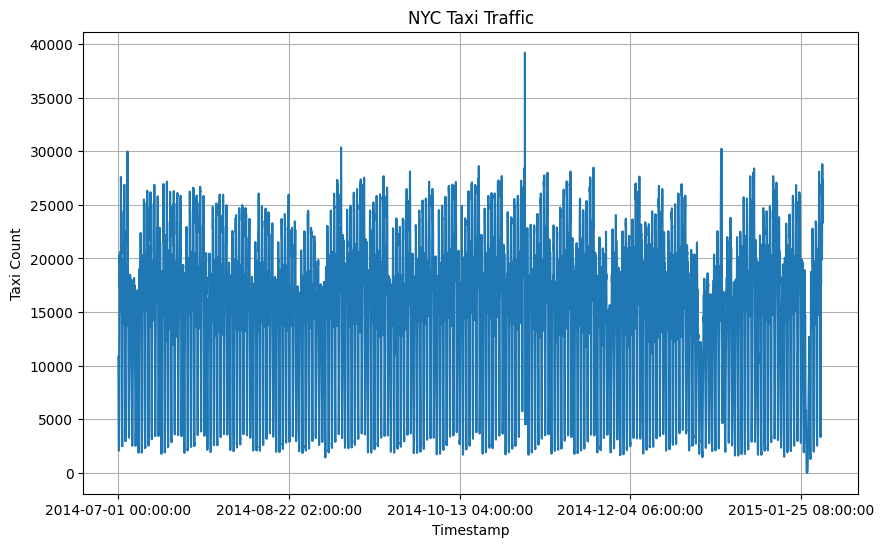

In [8]:
plot_series(
    x=timestamps,
    y=value,
    format="-",
    title="NYC Taxi Traffic",
    xlabel="Timestamp",
    ylabel="Taxi Count"
)

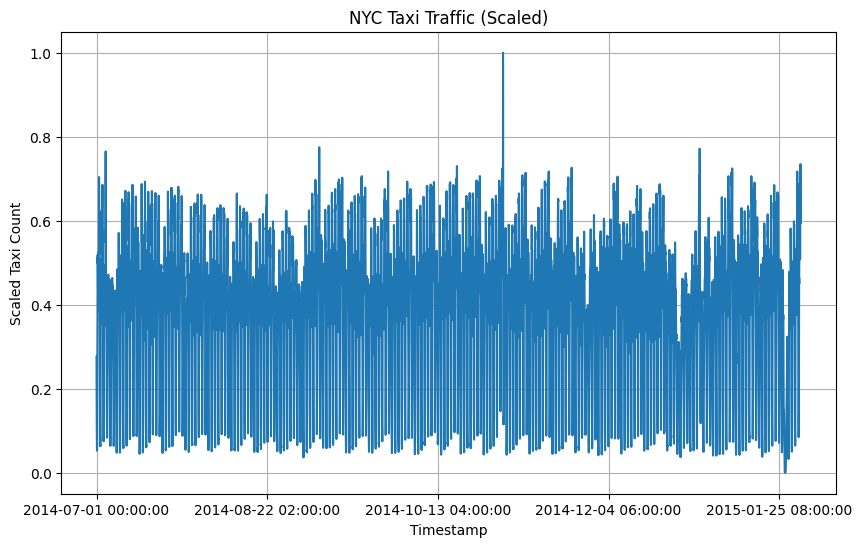

In [9]:
plot_series(
    x=timestamps,
    y=value_scaled,
    format="-",
    title="NYC Taxi Traffic (Scaled)",
    xlabel="Timestamp",
    ylabel="Scaled Taxi Count"
)

In [10]:
total_intervals = len(value_scaled)
split_time = int(total_intervals * 0.8)

train_time = timestamps[:split_time]
x_train = value_scaled[:split_time]

valid_time = timestamps[split_time:]
x_val = value_scaled[split_time:]

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")

Training set size: 8256
Validation set size: 2064


In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [12]:
window_size = 336
batch_size = 64
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.GRU(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 336, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 336, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,447 (204.87 KB)

 Trainable params: 52,447 (204.87 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
optimizer = tf.keras.optimizers.Adam()

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(
    train_set,
    epochs=100,
)

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0229 - mae: 0.1556
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 8.5559e-04 - mae: 0.0320
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 5.4095e-04 - mae: 0.0247
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 4.8006e-04 - mae: 0.0231
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 4.1812e-04 - mae: 0.0218
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 3.9125e-04 - mae: 0.0208
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 3.9103e-04 - mae: 0.0208
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 3.6380e-04 - mae: 0.0202
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 3.8014e-04 - mae: 0.0207
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 4.0109e-04 - mae: 0.0210
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 3.7786e-04 - mae: 0.0204
Epoch 12/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 3.7208e-04 - mae: 0.0205
Epoch 13/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/

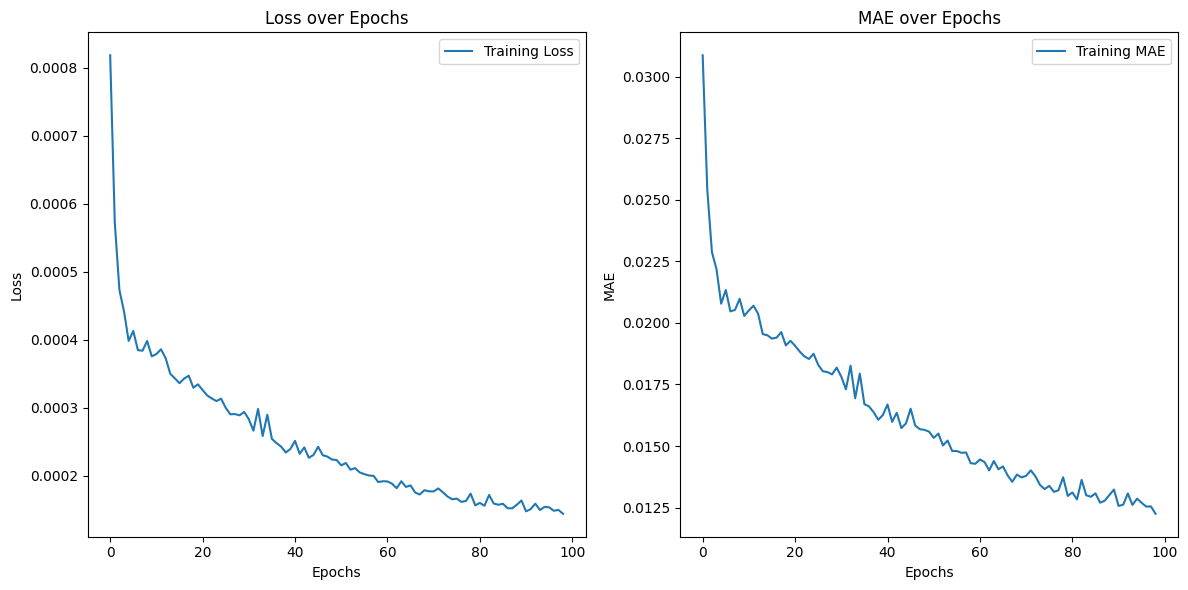

In [16]:
loss = history.history['loss'][1:]
mae = history.history['mae'][1:]
val_loss = history.history.get('val_loss')[1:] if 'val_loss' in history.history else None
val_mae = history.history.get('val_mae')[1:] if 'val_mae' in history.history else None
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
if val_mae:
    plt.plot(val_mae, label='Validation MAE', linestyle='--')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)

    return forecast

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


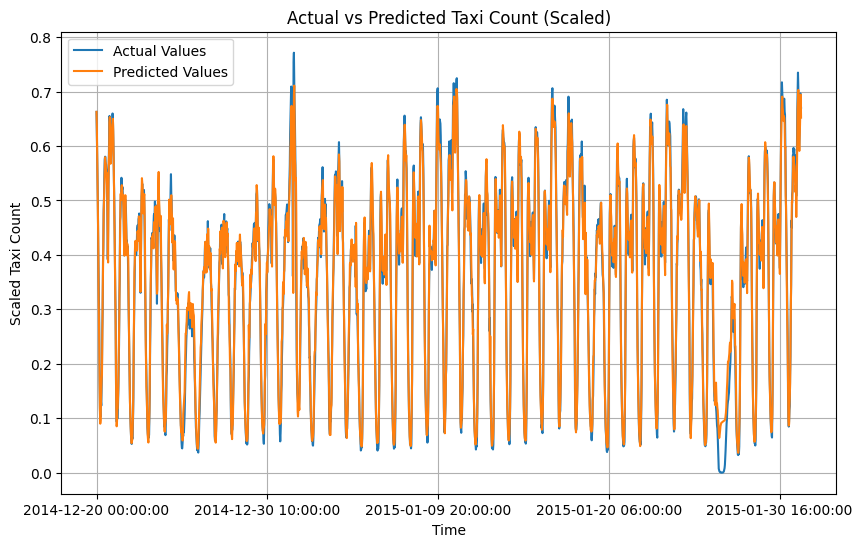

In [18]:
forecast_series = value_scaled[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()

plot_series(
    x=valid_time,
    y=(x_val, results),
    format="-",
    title="Actual vs Predicted Taxi Count (Scaled)",
    xlabel="Time",
    ylabel="Scaled Taxi Count",
    legend=["Actual Values", "Predicted Values"]
)

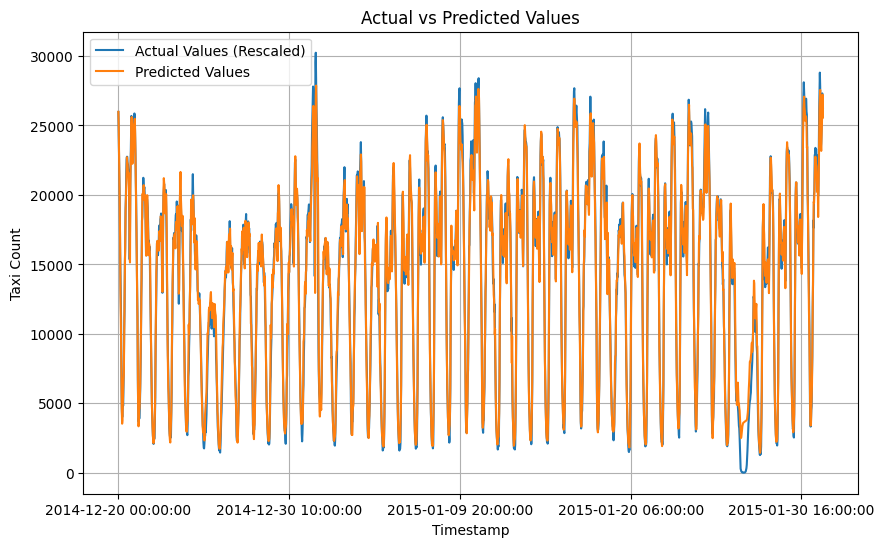

In [19]:
x_val_rescaled = scaler.inverse_transform(x_val.reshape(-1, 1)).flatten()
results_rescaled = scaler.inverse_transform(results.reshape(-1, 1)).flatten()

plot_series(
    x=valid_time,
    y=(x_val_rescaled, results_rescaled),
    title="Actual vs Predicted Values",
    xlabel="Timestamp",
    ylabel="Taxi Count",
    legend=["Actual Values (Rescaled)", "Predicted Values"]
)

In [20]:
mae_test = mean_absolute_error(x_val, forecast)
print(f"Validation Set MAE: {mae_test}")
percentage_error = mae_test * 100
print(f"On average, the model's predictions are off by {percentage_error:.2f}%")

Validation Set MAE: 0.01707069374098625
On average, the model's predictions are off by 1.71%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')